### Initialization environment

In [ ]:
%ls

In [ ]:
#For colab instance
from google.colab import drive
drive.mount('/content/drive')

In [13]:
!git clone https://github.com/cusniwtt/Automatic-Cell-Counting-in-Immunofluorescence-tissue.git
#For colab instance
#!cp "/content/drive/MyDrive/senior/Immunofluorescence images.zip" "/content"
#For local runtime
!cp /Users/cusniwtt/Downloads/Immunofluorescence\ images.zip /Users/cusniwtt/Documents/Playgrounds/content
!unzip -q 'Immunofluorescence images.zip'
!mv 'Immunofluorescence images' 'Automatic-Cell-Counting-in-Immunofluorescence-tissue'
!rm -rf '__MACOSX/'
!rm 'Immunofluorescence images.zip'
!mv 'Automatic-Cell-Counting-in-Immunofluorescence-tissue' 'root'
!mkdir 'root/Dataset'
!mkdir 'root/Dataset/4x4'


Cloning into 'Automatic-Cell-Counting-in-Immunofluorescence-tissue'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 160 (delta 89), reused 114 (delta 45), pack-reused 0
Receiving objects: 100% (160/160), 4.02 MiB | 4.76 MiB/s, done.
Resolving deltas: 100% (89/89), done.


In [14]:
# Do first time before extract zip
# If "Immunofluorescence images" folder is already split. Don't run this code
import os
from tqdm import tqdm

dapi = []
fitc = []
merge = []
root = 'root/Immunofluorescence images/'

for file in tqdm(sorted(os.listdir(root))):
    if file.endswith('.tif.tif'):
        os.rename(root + file, root + file[:-4])
        file = file[:-4]

    if 'DAPI' in file:
        dapi.append(file)
    elif 'FITC' in file:
        fitc.append(file)
    elif 'merge' in file:
        merge.append(file)


print('DAPI: ', len(dapi))
print('FITC: ', len(fitc))
print('Merge: ', len(merge))

os.mkdir(root + 'DAPI')
os.mkdir(root + 'FITC')
os.mkdir(root + 'Merge')

for file in tqdm(dapi):
    os.rename(root + file, root + 'DAPI/' + file)

for file in tqdm(fitc):
    os.rename(root + file, root + 'FITC/' + file)

for file in tqdm(merge):
    os.rename(root + file, root + 'Merge/' + file)

print('Complete moving files')

100%|█████████████████████████████████████████████████████████| 591/591 [00:00<00:00, 149841.85it/s]


DAPI:  197
FITC:  197
Merge:  196


100%|██████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 12758.74it/s]

Complete moving files


In [15]:
# For slicer image in ratio
import os
import cv2
from tqdm import tqdm

# Image slicer
def imgSlicer(img, type = 'd8'):
    # Slice ratio (base on 1920x1536)
    slice_ratio = {
        'd2': [960, 768, 2],
        'd4': [480, 384, 4],
        'd8': [240, 192, 8],
        'd16': [120, 96, 16],
    }
    # Slice image
    img_slice = []
    x = 0
    y = 0
    for i in range(0, slice_ratio[type][2]):
        for j in range(0, slice_ratio[type][2]):
            temp = img[y:y+slice_ratio[type][1]-1, x:x+slice_ratio[type][0]-1]
            img_slice.append(temp)
            x += slice_ratio[type][0]
        x = 0
        y += slice_ratio[type][1]
    return img_slice

# Set path
paths = root + 'DAPI'

for file in tqdm(sorted(os.listdir(paths))):
    path = paths + '/' + file
    img = cv2.imread(path, 1)
    img_list = imgSlicer(img, type='d4')

    init = 0
    for each in img_list:
        row = init // 4
        col = init % 4
        filename = file[:-4] + '_' + str(row) + '_' + str(col) + '.png'
        cv2.imwrite('root/Dataset/4x4/' + filename, each)
        init += 1
        if init == 16:
            init = 0

100%|█████████████████████████████████████████████████████████████| 197/197 [00:16<00:00, 11.82it/s]


In [16]:
print(len(os.listdir('root/Dataset/4x4')))

3152


# Baseline
Import supplyment library and function

In [17]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from skimage import data
from skimage.filters import threshold_multiotsu

In [18]:
# Because opencv reads images in BGR format, we need to convert it to RGB format
def cnvShowImage(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()

# Image slicer
def imgSlicer(img, type = 'd8'):
    # Slice ratio (base on 1920x1536)
    slice_ratio = {
        'd2': [960, 768, 2],
        'd4': [480, 384, 4],
        'd8': [240, 192, 8],
        'd16': [120, 96, 16],
    }
    # Slice image
    img_slice = []
    x = 0
    y = 0
    for i in range(0, slice_ratio[type][2]):
        for j in range(0, slice_ratio[type][2]):
            temp = img[y:y+slice_ratio[type][1]-1, x:x+slice_ratio[type][0]-1]
            img_slice.append(temp)
            x += slice_ratio[type][0]
        x = 0
        y += slice_ratio[type][1]
    return img_slice

# Plot Histogram of image
def plotHistogram(img):
    plt.hist(img.ravel(), 256, [0,256], color='crimson')
    plt.ylabel("Number Of Pixels", color='crimson')
    plt.xlabel("Pixel Intensity- From 0-255", color='crimson')
    plt.title("Histogram Showing Pixel Intensity And Corresponding Number Of Pixels", color='crimson')
    plt.show()

# Create a mask
edge_detection_K = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharpening_K = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])

Get file path

In [20]:
root = 'root/Immunofluorescence images/DAPI'
files = os.listdir(root)
files.sort()
if '.DS_Store' in files:    # for macOS file system
    files.remove('.DS_Store')
paths = []
for path in files:
    path = root + '/' + path
    paths.append(path)
print(paths[0:3])
print(len(paths))

['root/Immunofluorescence images/DAPI/1H_Nrf2_No_ADT_1_DAPI.tif', 'root/Immunofluorescence images/DAPI/1H_Nrf2_No_ADT_2_DAPI.tif', 'root/Immunofluorescence images/DAPI/1H_Nrf2_No_ADT_3_DAPI.tif']
197


## Input Image

Preview image

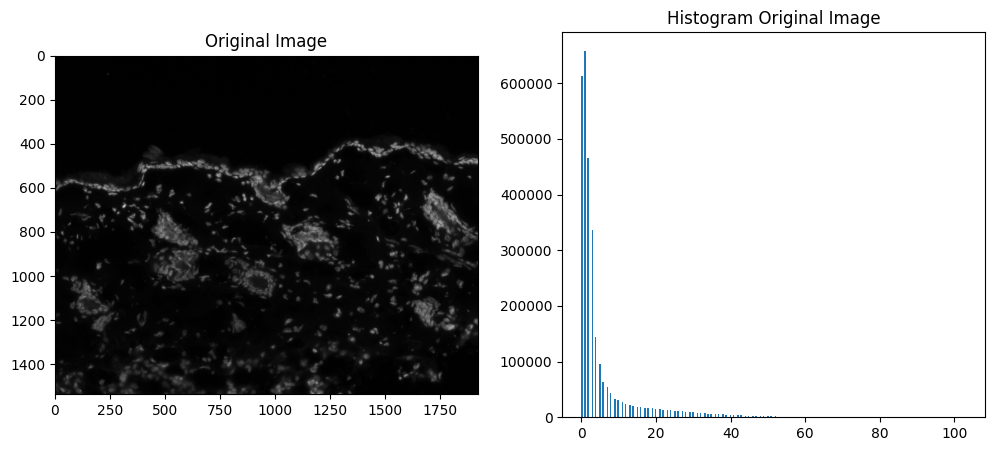

In [21]:
# read images
source = paths[170]
img = cv2.imread(source, 0)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image')
ax[1].hist(img.ravel(), bins=256)
ax[1].set_title('Histogram Original Image')
plt.show()

## Preprocessing
- HE & CLAHE
- Gaussian & Median blur

### HE & CLAHE

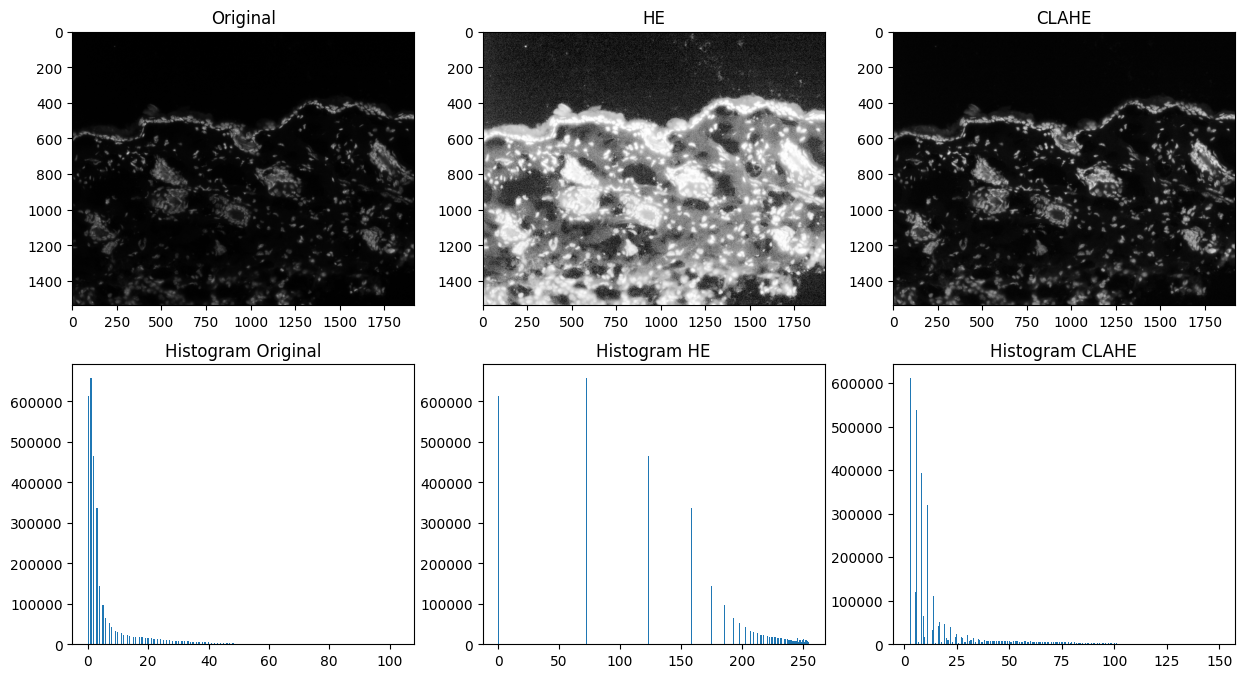

In [22]:
# create HE
img_he = cv2.equalizeHist(img)
# create CLAHE
img_clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(img)

fig, ax = plt.subplots(2, 3, figsize=(15, 8))
# Plot image
ax[0][0].imshow(img, cmap='gray')
ax[0][0].set_title('Original')
ax[0][1].imshow(img_he, cmap='gray')
ax[0][1].set_title('HE')
ax[0][2].imshow(img_clahe, cmap='gray')
ax[0][2].set_title('CLAHE')
# Plot Hist
ax[1][0].hist(img.ravel(), bins=256)
ax[1][0].set_title('Histogram Original')
ax[1][1].hist(img_he.ravel(), bins=256)
ax[1][1].set_title('Histogram HE')
ax[1][2].hist(img_clahe.ravel(), bins=256)
ax[1][2].set_title('Histogram CLAHE')
plt.show()

### Gaussian Blur & Median Blur

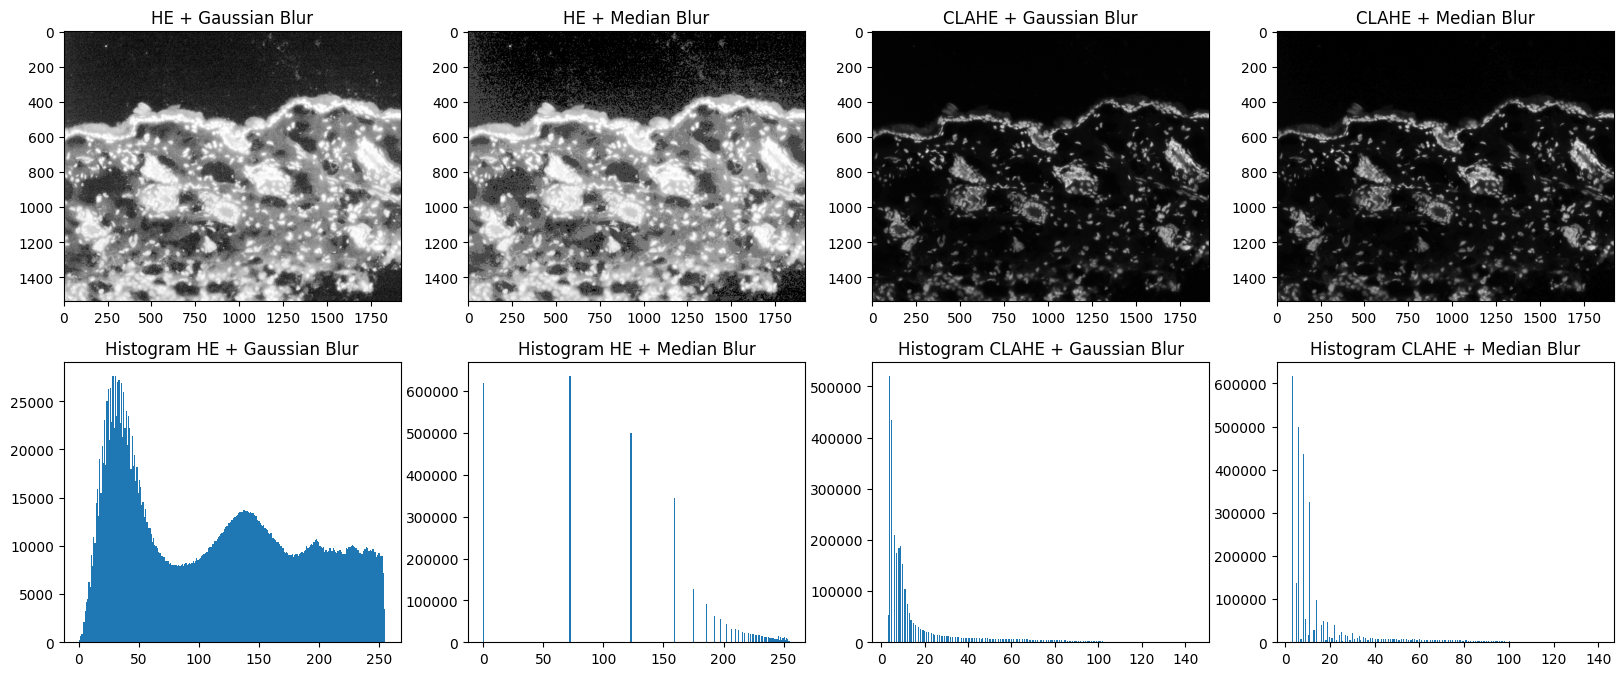

In [23]:
# Add Gaussian blur
img_he_gssblur = cv2.GaussianBlur(img_he, (5,5), 0)
img_clahe_geeblur = cv2.GaussianBlur(img_clahe, (5,5), 0)
# Add Median Blur
img_he_mdblur = cv2.medianBlur(img_he, 5)
img_clahe_mdblur = cv2.medianBlur(img_clahe, 5)

fig, ax = plt.subplots(2, 4, figsize=(20, 8))
# Plot image
ax[0][0].imshow(img_he_gssblur, cmap='gray')
ax[0][0].set_title('HE + Gaussian Blur')
ax[0][1].imshow(img_he_mdblur, cmap='gray')
ax[0][1].set_title('HE + Median Blur')
ax[0][2].imshow(img_clahe_geeblur, cmap='gray')
ax[0][2].set_title('CLAHE + Gaussian Blur')
ax[0][3].imshow(img_clahe_mdblur, cmap='gray')
ax[0][3].set_title('CLAHE + Median Blur')
# Plot Hist
ax[1][0].hist(img_he_gssblur.ravel(), bins=256)
ax[1][0].set_title('Histogram HE + Gaussian Blur')
ax[1][1].hist(img_he_mdblur.ravel(), bins=256)
ax[1][1].set_title('Histogram HE + Median Blur')
ax[1][2].hist(img_clahe_geeblur.ravel(), bins=256)
ax[1][2].set_title('Histogram CLAHE + Gaussian Blur')
ax[1][3].hist(img_clahe_mdblur.ravel(), bins=256)
ax[1][3].set_title('Histogram CLAHE + Median Blur')
plt.show()

### Multi-Otsu method

threshold_multiotsu:  86
threshold_multiotsu:  172


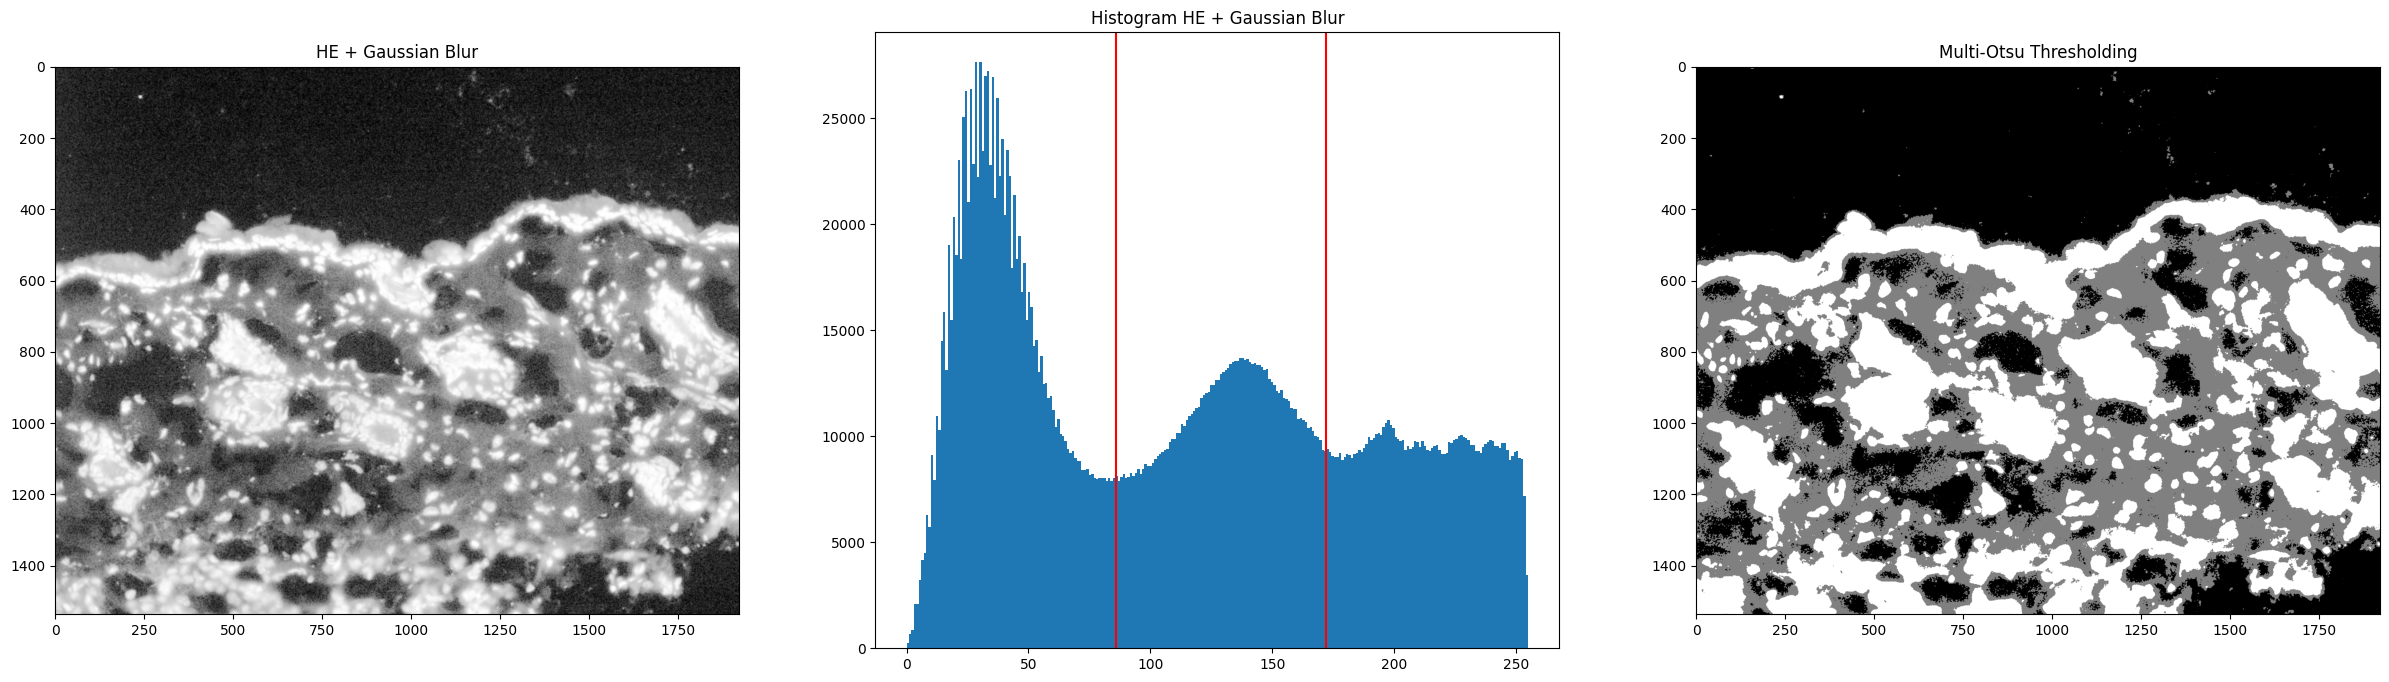

In [24]:
input = img_he_gssblur
# Applying multi-Otsu threshold for the default value, generating three classes.
thres = threshold_multiotsu(input, classes=3)
# Using the threshold values, we generate the three regions.
regions = np.digitize(input, bins=thres)

fig, ax = plt.subplots(1, 3, figsize=(30, 8))
# Plotting the original image.
ax[0].imshow(input, cmap='gray')
ax[0].set_title('HE + Gaussian Blur')
# Plotting the histogram and the two thresholds obtained from multi-Otsu.
ax[1].hist(input.ravel(), bins=256)
ax[1].set_title('Histogram HE + Gaussian Blur')
for t in thres:
    ax[1].axvline(t, color='r')
    print('threshold_multiotsu: ', t)
# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='gray')
ax[2].set_title('Multi-Otsu Thresholding')
plt.show()

threshold_multiotsu:  1
threshold_multiotsu:  123


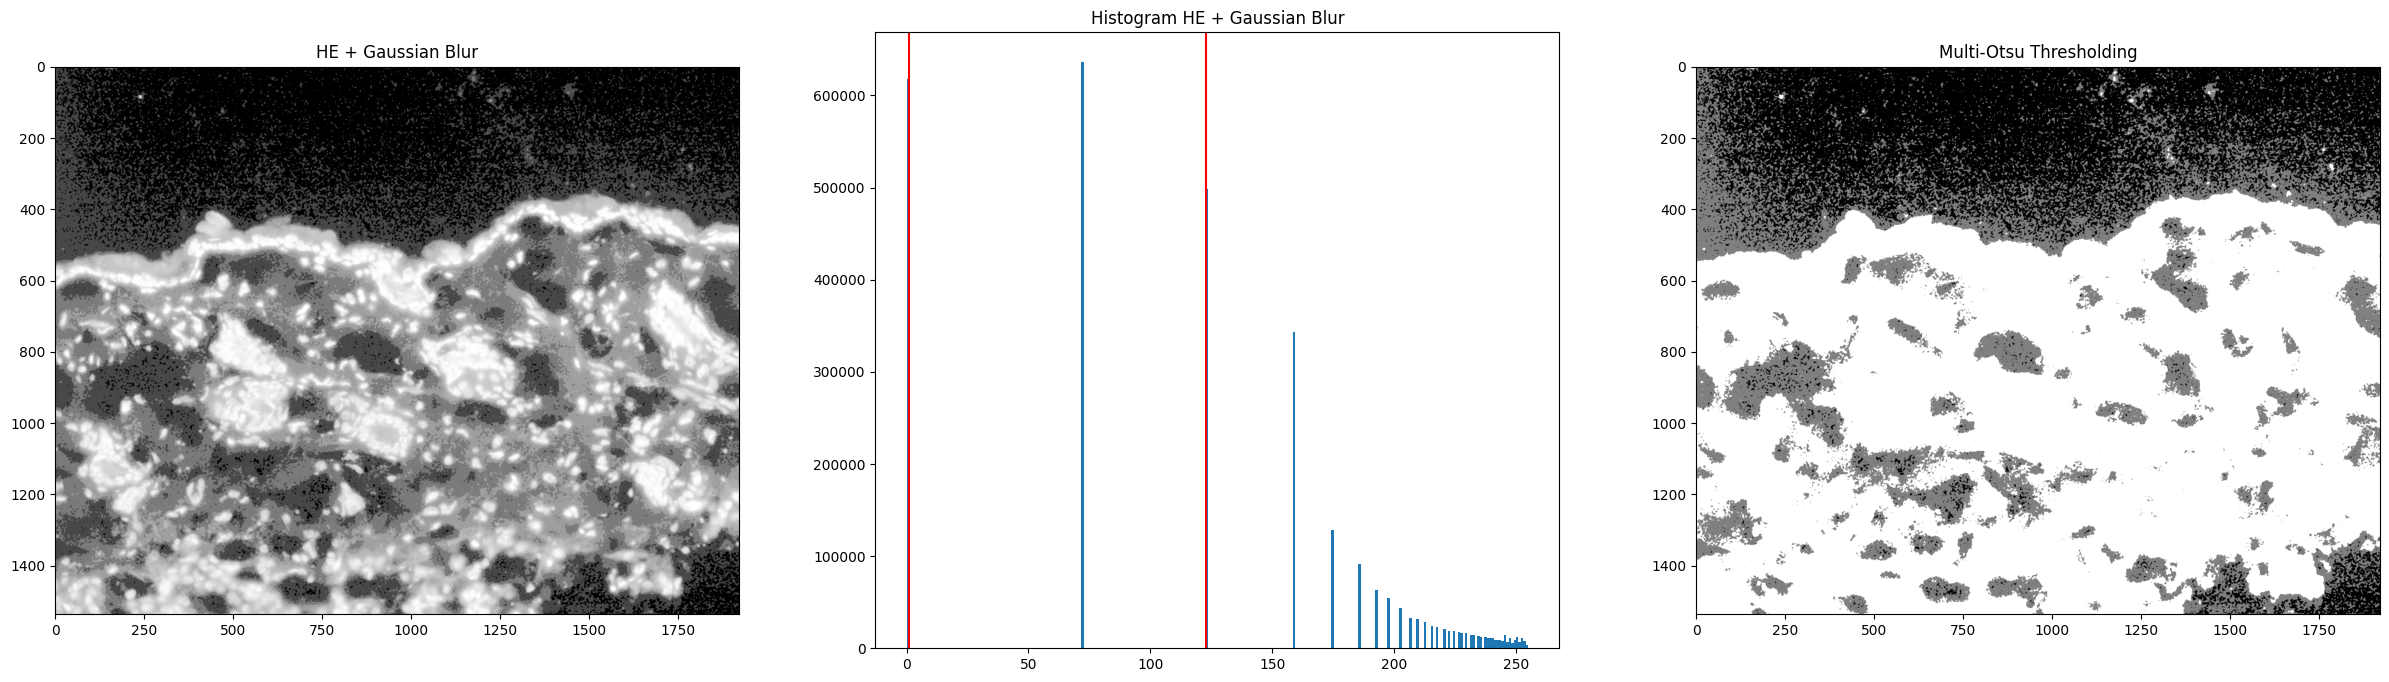

In [25]:
input = img_he_mdblur
# Applying multi-Otsu threshold for the default value, generating three classes.
thres = threshold_multiotsu(input, classes=3)
# Using the threshold values, we generate the three regions.
regions = np.digitize(input, bins=thres)

fig, ax = plt.subplots(1, 3, figsize=(30, 8))
# Plotting the original image.
ax[0].imshow(input, cmap='gray')
ax[0].set_title('HE + Gaussian Blur')
# Plotting the histogram and the two thresholds obtained from multi-Otsu.
ax[1].hist(input.ravel(), bins=256)
ax[1].set_title('Histogram HE + Gaussian Blur')
for t in thres:
    ax[1].axvline(t, color='r')
    print('threshold_multiotsu: ', t)
# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='gray')
ax[2].set_title('Multi-Otsu Thresholding')
plt.show()

### Manual Thresholding

Threshold 1:  100
Threshold 2:  220


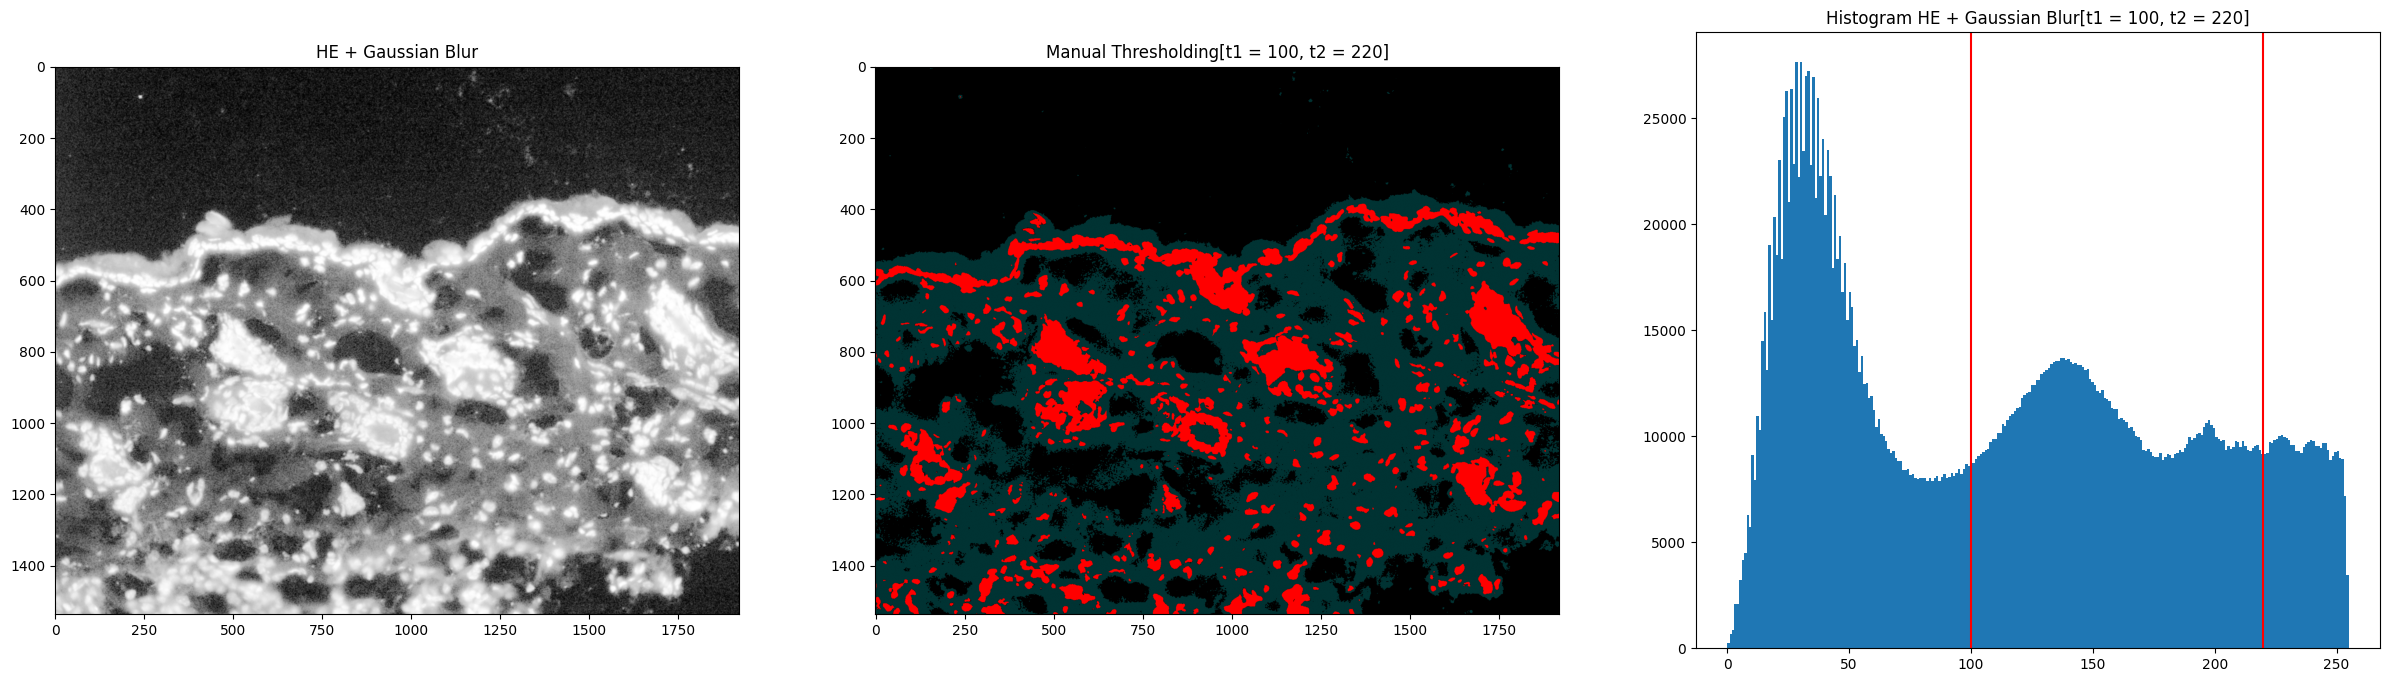

In [26]:
min = 0
max = 255
t1, t2 = 100, 220

input = img_he_gssblur
region1 = (input >= min) & (input < t1)
region2 = (input >= t1+1) & (input < t2)
region3 = (input >= t2+1) & (input <= max)
all_region = np.zeros((input.shape[0], input.shape[1], 3))
all_region[region1] = (0, 0, 0)
all_region[region2] = (0, 0.2, 0.2)
all_region[region3] = (1, 0, 0)

fig, ax = plt.subplots(1, 3, figsize=(30, 8))
thres_value = '[t1 = {}, t2 = {}]'.format(t1, t2)
ax[0].imshow(input, cmap='gray')
ax[0].set_title('HE + Gaussian Blur')
ax[1].imshow(all_region)
ax[1].set_title('Manual Thresholding' + thres_value)
ax[2].hist(input.ravel(), bins=256)
ax[2].set_title('Histogram HE + Gaussian Blur' + thres_value)
ax[2].axvline(t1, color='r')
ax[2].axvline(t2, color='r')
print('Threshold 1: ', t1)
print('Threshold 2: ', t2)
plt.show()

Threshold 1:  123
Threshold 2:  220


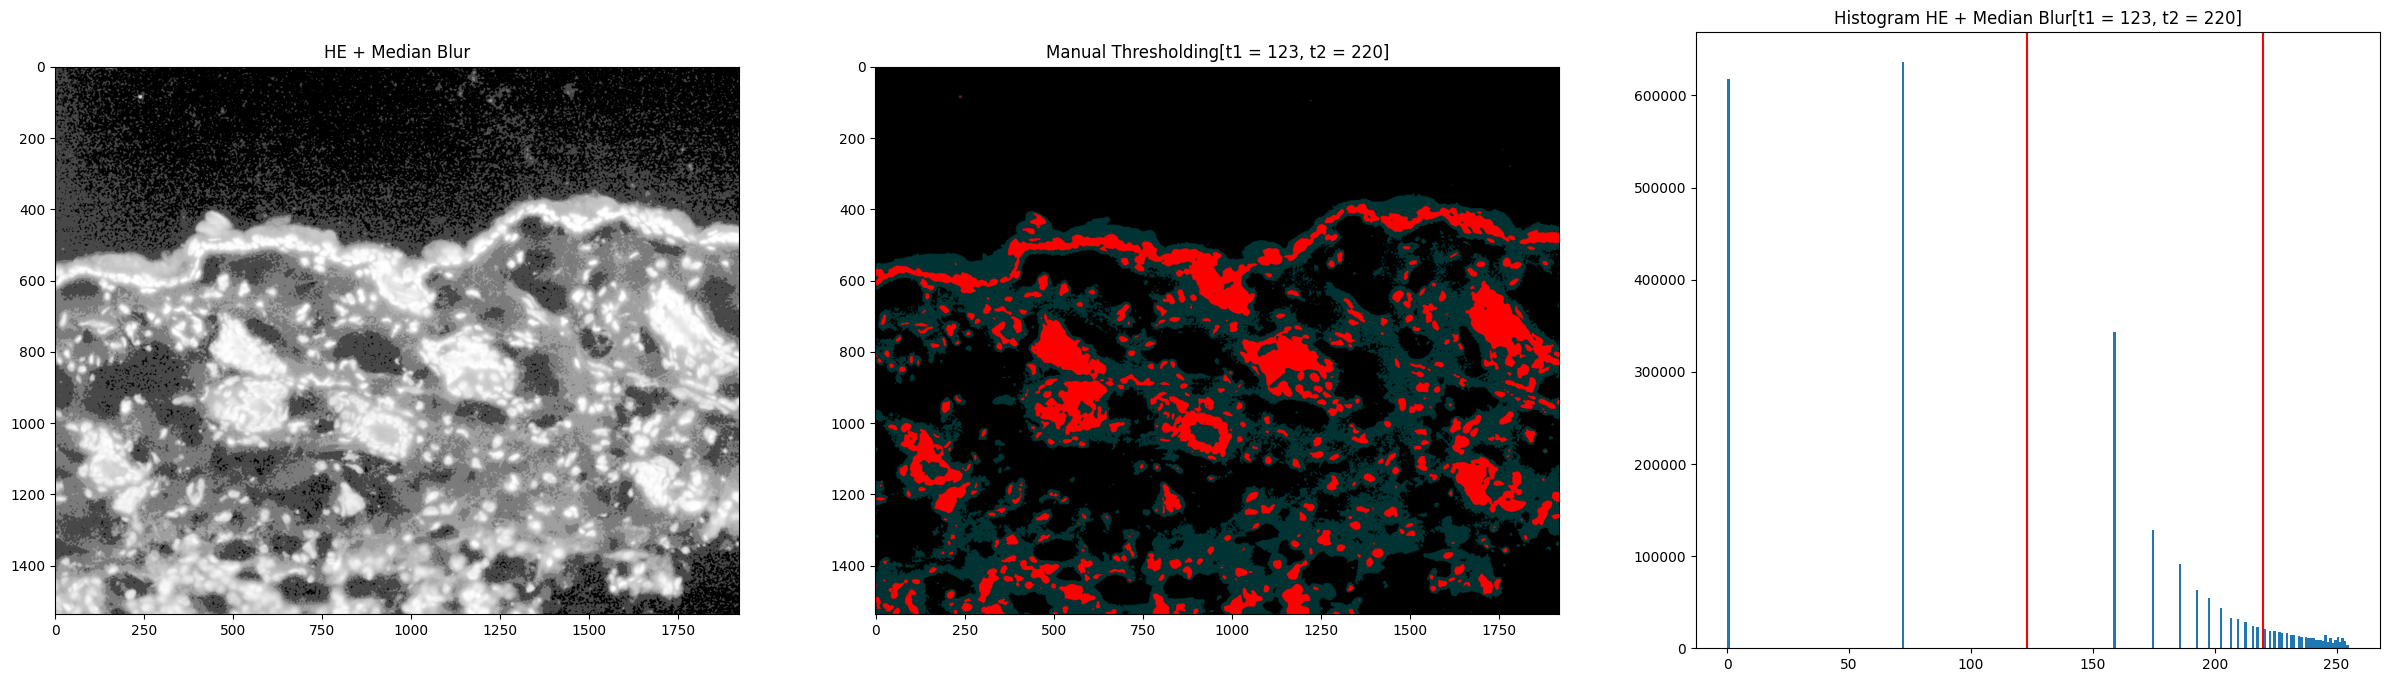

In [27]:
min = 0
max = 255
t1, t2 = 123, 220

input = img_he_mdblur
region1 = (input >= min) & (input < t1)
region2 = (input >= t1+1) & (input < t2)
region3 = (input >= t2+1) & (input <= max)
all_region = np.zeros((input.shape[0], input.shape[1], 3))
all_region[region1] = (0, 0, 0)
all_region[region2] = (0, 0.2, 0.2)
all_region[region3] = (1, 0, 0)

fig, ax = plt.subplots(1, 3, figsize=(30, 8))
thres_value = '[t1 = {}, t2 = {}]'.format(t1, t2)
ax[0].imshow(input, cmap='gray')
ax[0].set_title('HE + Median Blur')
ax[1].imshow(all_region)
ax[1].set_title('Manual Thresholding' + thres_value)
ax[2].hist(input.ravel(), bins=256)
ax[2].set_title('Histogram HE + Median Blur' + thres_value)
ax[2].axvline(t1, color='r')
ax[2].axvline(t2, color='r')
print('Threshold 1: ', t1)
print('Threshold 2: ', t2)
plt.show()

# Automated segmentation of overlapped nuclei using concave point detection and segment grouping
https://www.sciencedirect.com/science/article/pii/S0031320317302443

Preview image

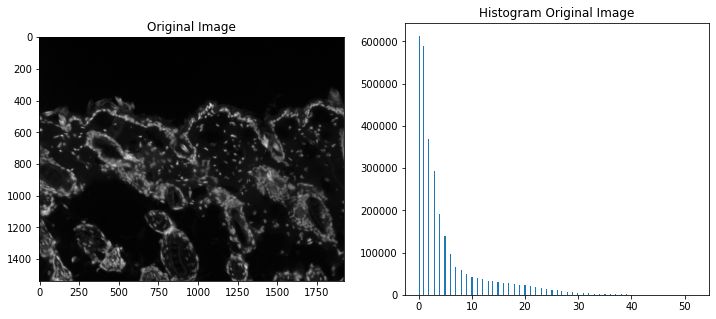

In [ ]:
# read images
source = paths[28]
img = cv2.imread(source, 0)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image')
ax[1].hist(img.ravel(), bins=256)
ax[1].set_title('Histogram Original Image')
plt.show()

## Level set segmentation
https://github.com/Ramesh-X/Level-Set

In [ ]:
!git clone https://github.com/cusniwtt/Level-Set.git
!mv '/content/Level-Set/lv_set' '/content/'
!rm -rf /content/Level-Set

Cloning into 'Level-Set'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 64 (delta 16), reused 25 (delta 11), pack-reused 31
Unpacking objects: 100% (64/64), done.


Import Supplyment library and Function

In [ ]:
"""
This python code demonstrates an edge-based active contour model as an application of the
Distance Regularized Level Set Evolution (DRLSE) formulation in the following paper:

  C. Li, C. Xu, C. Gui, M. D. Fox, "Distance Regularized Level Set Evolution and Its Application to Image Segmentation",
     IEEE Trans. Image Processing, vol. 19 (12), pp. 3243-3254, 2010.

Author: Ramesh Pramuditha Rathnayake
E-mail: rsoft.ramesh@gmail.com

Released Under MIT License
"""

import numpy as np
from skimage.io import imread

from lv_set.find_lsf import *
from lv_set.potential_func import *
from lv_set.show_fig import *


def gourd_params(path):
    img = imread(path, True)
    img = np.interp(img, [np.min(img), np.max(img)], [0, 255])

    # initialize LSF as binary step function
    c0 = 2
    initial_lsf = c0 * np.ones(img.shape)
    # generate the initial region R0 as two rectangles
    initial_lsf[24:35, 19:25] = -c0
    initial_lsf[24:35, 39:50] = -c0

    # parameters
    return {
        'img': img,
        'initial_lsf': initial_lsf,
        'timestep': 1,  # time step
        'iter_inner': 10,
        'iter_outer': 30,
        'lmda': 5,  # coefficient of the weighted length term L(phi)
        'alfa': -3,  # coefficient of the weighted area term A(phi)
        'epsilon': 1.5,  # parameter that specifies the width of the DiracDelta function
        'sigma': 0.8,  # scale parameter in Gaussian kernel
        'potential_function': DOUBLE_WELL,
    }


def two_cells_params(path):
    img = imread(path, True)
    img = np.interp(img, [np.min(img), np.max(img)], [0, 255])

    # initialize LSF as binary step function
    c0 = 2
    initial_lsf = c0 * np.ones(img.shape)
    # generate the initial region R0 as two rectangles
    initial_lsf[9:55, 9:75] = -c0

    # parameters
    return {
        'img': img,
        'initial_lsf': initial_lsf,
        'timestep': 5,  # time step
        'iter_inner': 5,
        'iter_outer': 40,
        'lmda': 5,  # coefficient of the weighted length term L(phi)
        'alfa': 1.5,  # coefficient of the weighted area term A(phi)
        'epsilon': 1.5,  # parameter that specifies the width of the DiracDelta function
        'sigma': 1.5,  # scale parameter in Gaussian kernel
        'potential_function': DOUBLE_WELL,
    }

In [ ]:
#params = gourd_params(source)
params = two_cells_params('/content/root/Dataset/4x4/1H_Nrf2_No_ADT_4_DAPI_1_3.png')
phi = find_lsf(**params)

show fig 2 first time
show fig 2 for 0 time
show fig 2 for 1 time
show fig 2 for 2 time
show fig 2 for 3 time
show fig 2 for 4 time
show fig 2 for 5 time
show fig 2 for 6 time
show fig 2 for 7 time
show fig 2 for 8 time
show fig 2 for 9 time
show fig 2 for 10 time
show fig 2 for 11 time
show fig 2 for 12 time
show fig 2 for 13 time
show fig 2 for 14 time
show fig 2 for 15 time
show fig 2 for 16 time
show fig 2 for 17 time
show fig 2 for 18 time
show fig 2 for 19 time
show fig 2 for 20 time
show fig 2 for 21 time
show fig 2 for 22 time
show fig 2 for 23 time
show fig 2 for 24 time
show fig 2 for 25 time
show fig 2 for 26 time
show fig 2 for 27 time
show fig 2 for 28 time
show fig 2 for 29 time
show fig 2 for 30 time
show fig 2 for 31 time
show fig 2 for 32 time
show fig 2 for 33 time
show fig 2 for 34 time
show fig 2 for 35 time
show fig 2 for 36 time
show fig 2 for 37 time
show fig 2 for 38 time


/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/art3d.py:304: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._segments3d = np.asanyarray(segments)


show fig 2 for 39 time


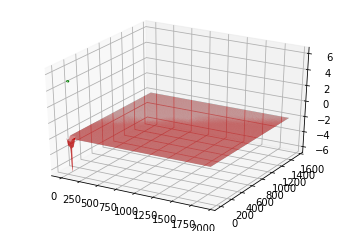

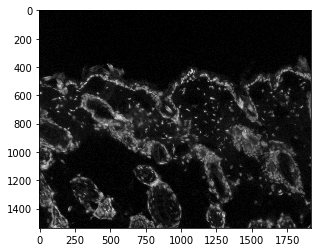

In [ ]:
from skimage import measure

plt.ion()
fig1 = plt.figure(1)
fig2 = plt.figure(2)

fig2.clf()
contours = measure.find_contours(phi, 0)
ax2 = fig2.add_subplot(111)
ax2.imshow(img, interpolation='nearest', cmap=plt.get_cmap('gray'))
for n, contour in enumerate(contours):
  ax2.plot(contour[:, 1], contour[:, 0], linewidth=2)

fig1.clf()
ax1 = fig1.add_subplot(111, projection='3d')
y, x = phi.shape
x = np.arange(0, x, 1)
y = np.arange(0, y, 1)
X, Y = np.meshgrid(x, y)
ax1.plot_surface(X, Y, -phi, rstride=2, cstride=2, color='r', linewidth=0, alpha=0.6, antialiased=True)
ax1.contour(X, Y, phi, 0, colors='g', linewidths=2)
plt.show()

# Automated Image Processing Workflow for Morphological Analysis of Fluorescence Microscopy Cell Images
https://link.springer.com/article/10.1007/s11837-021-04707-w

In [48]:
%pwd

'/Users/cusniwtt/Documents/Playgrounds/content'

In [50]:
!git clone https://github.com/SvenPVoigt/ImageMKS.git

fatal: destination path 'ImageMKS' already exists and is not an empty directory.
cp: /ImageMKS/imagemks/: No such file or directory


In [51]:
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageEnhance
from os.path import expanduser

from imagekms.rw import rwformat

ImportError: ignored

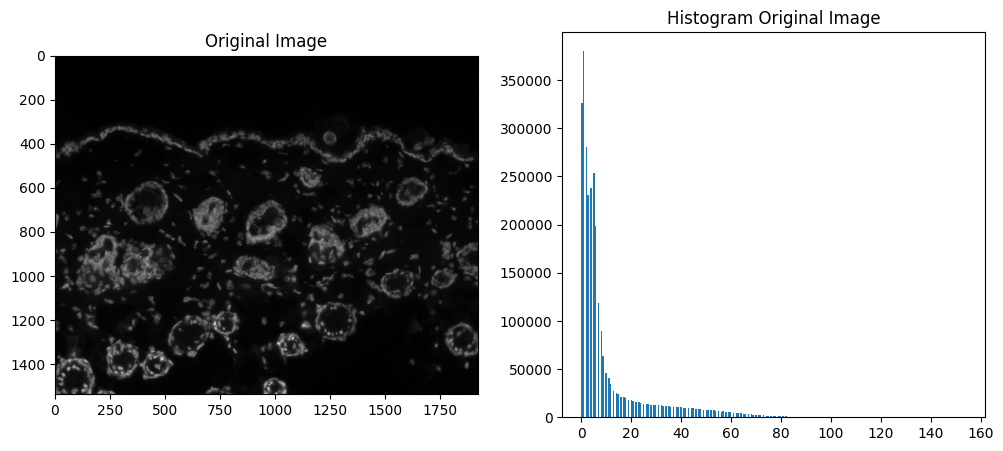

In [29]:
# read images
source = paths[50]
img = cv2.imread(source, 0)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image')
ax[1].hist(img.ravel(), bins=256)
ax[1].set_title('Histogram Original Image')
plt.show()